In [31]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

##  1. Data with odds

There is a break from  '2020-03-11 to 2020-05-16' because of COVID-19

In [32]:
df = pd.read_csv("../data/final_data/final_data.csv")
df.Date = pd.to_datetime(df.Date)
# subset of 2019-2020 Season Pre-COVID
df_1920 = df[(df.Season == '2019-2020') & (df.Date<'2020-05')]

the European Odds. It’s simple: they tell me how much I will get back if I bet 1. For example, Bet365 gives an odds of 2.4 for the event that Arsenal beating Man United, 3.6 for a draw and 3 for Manu winning. This means that I would have come out of the bet with 2.4 (a 1.4 profit) in my pocket if I had put a 1 bet for Arsenal.

In [33]:
# Create Max, Avg odds for home, draw and away
odd_cols = ['OddsB365_Home',
       'OddsB365_Draw', 'OddsB365_Away', 'OddsBW_Home', 'OddsBW_Draw',
       'OddsBW_Away', 'OddsIW_Home', 'OddsIW_Draw', 'OddsIW_Away',
       'OddsPS_Home', 'OddsPS_Draw', 'OddsPS_Away', 'OddsWH_Home',
       'OddsWH_Draw', 'OddsWH_Away', 'OddsVC_Home', 'OddsVC_Draw',
       'OddsVC_Away', 'OddsPSC_Home', 'OddsPSC_Draw', 'OddsPSC_Away']
cols_home = [x for x in odd_cols if 'Home' in x]
cols_draw = [x for x in odd_cols if 'Draw' in x]
cols_away = [x for x in odd_cols if 'Away' in x]

In [34]:
df_1920[['Max_Home', 'Mean_Home', 'Median_Home']] = df_1920[cols_home].agg(["max", "mean", "median"], axis = 1).round(3)
df_1920[['Max_Draw', 'Mean_Draw', 'Median_Draw']] = df_1920[cols_draw].agg(["max", "mean", "median"], axis = 1).round(3)
df_1920[['Max_Away', 'Mean_Away', 'Median_Away']] = df_1920[cols_away].agg(["max", "mean", "median"], axis = 1).round(3)

Adding new featues: Market maximum home win odds, Market maximum draw win odds, Market maximum away win odds; Same for mean and median.

In [35]:
# Add Result
condition = [df_1920['Goals_Home']==df_1920['Goals_Away'],
            df_1920['Goals_Home'] > df_1920['Goals_Away'],
            df_1920['Goals_Home'] < df_1920['Goals_Away']]
value = ["Draw", "Home", "Away"]
df_1920["Result"] = np.select(condition, value)
df_1920.reset_index(inplace=True)
# df_1920[['Goals_Home', 'Goals_Away', 'Result']].head()

In [36]:
df_1920.shape

(1315, 83)

In [37]:
key_cols = ['League', 'Season', 'Date', 'Team_Home', 'Team_Away','Goals_Home', 'Goals_Away']
New_cols = ['Max_Home', 'Mean_Home', 'Median_Home','Max_Draw', 'Mean_Draw', 'Median_Draw','Max_Away', 'Mean_Away', 'Median_Away', 'Result']

# 2.1 Simulation for Binary classes classification
Predict whether the home win or not.

For binary classfication, the simulation method is 
$$f=\frac{\text { Edges }}{\text { Odds }}=\frac{p_{W}^{*} \times x-\left(1-p_{W}^{*}\right)}{x}$$
Where $p_{W}^{*}=\frac{1}{\frac{1}{n} \times \sum_{1}^{n} x_{i}}$

Only make a bet, when home predicted probability is greater than 30%

In [24]:
class Simulation_Bet_binary():
    def __init__(self, df, cols_needed, probas, total_budget, budget_per_game=None):
        """
        Probas: array of (n, 3) Each columns is the probability of Home, notHome, respectively.
        Cols_needed: Required: "Result", 
                                'Max_Home', 'Mean_Home'          
        """
        self.n_games = df.shape[0]
        self.df_res = df.copy()[cols_needed]
        self.df_res[["H_proba", "NonHome_proba"]] = probas
        self.df_res["Prediction"] = self.df_res[["H_proba", "NonHome_proba"]].idxmax(axis=1).replace({"NonHome_proba": "nonHome", "H_proba": "Home"})
    
        if not total_budget:
            print("There are in total {} games, and budget per game is ${}.".format(n_games, budget_per_game))
        else:
            budget_per_game = total_budget/n_games
            print("There are in total {} games, total budget is ${}, and budget per game is ${}.".format(n_games, total_budget, budget_per_game))
        
        self.budget_per_game = budget_per_game
        
    def make_simulation(self):
        # simulation 1
        print("="*10, "Simulation: Make bet once at a time. Since it's binary, only bet when home probability greater than 30%","="*10)
        df_sim1 = self.df_res.copy()
        # ML model decide which result to bet on
        # With the prediction, I find the highest odds among 7 online betting houses. This means if I win, I get the highest profit possible. This will be the odds at which I place my bet.
       
        df_sim1["bet_or_not"] = df_sim1["H_proba"] > 1/3
        # if we make a bet, and the result is 'Home', then profit would be odd -1, else profit be -1
        df_sim1["Profit_per_dollar"] = np.where((df_sim1["bet_or_not"])&(df_sim1["Result"] == "Home"), df_sim1["Max_Home"]-1, -1)
        # Decide how much to put in (fraction)
        # We aggregate all the odds from many different betting houses, to get a better reflection of how bookmakers view the probability of an event
        df_sim1["Pw_odds"] = np.nan
        df_sim1.loc[df_sim1["Prediction"]=="Home", "Pw_odds"] = 1/df_sim1["Mean_Home"]
        df_sim1["Fraction"] = (df_sim1["Pw_odds"] * df_sim1["Max_Home"] - (1-df_sim1["Pw_odds"] ))/df_sim1["Max_Home"]

        df_sim1["Putin"] =  self.budget_per_game * df_sim1["Fraction"] 
        df_sim1["Profit"] = df_sim1["Putin"]  * df_sim1["Profit_per_dollar"]
        
        return df_sim1
    

$$f=\frac{\text { Edges }}{\text { Odds }}=\frac{p_{W}^{*} \times x-\left(1-p_{W}^{*}\right)}{x}$$
Where $p_{W}^{*}=\frac{1}{\frac{1}{n} \times \sum_{1}^{n} x_{i}}$

### Import model here (Only probability is needed here)

In [114]:
# Here we will need a model to predict the probability of H, notH for each games
df_bi = pd.read_csv("home_win_predictions.csv")
df_bi.Date = pd.to_datetime(df_bi.Date)
# subset of 2019-2020 Season Pre-COVID
df_bi = df_bi[(df_bi.Season == '2019-2020') & (df_bi.Date<'2020-05')]
proba_bi = pd.concat([df_bi.pred_prob_home_win, 1-df_bi.pred_prob_home_win],axis=1).values
# # The following part is simulated probability
# n_games = df_1920.shape[0]
# sim_proba = np.random.random((n_games, 2))
# # normalize it
# sim_proba = sim_proba/sim_proba.sum(axis=1).reshape(-1,1)

In [116]:
cols =  key_cols + New_cols
# change the probability here
sim = Simulation_Bet_binary(df_1920, cols_needed=cols, probas=proba_bi, total_budget=1_000_000, budget_per_game=None)
sim1 = sim.make_simulation()

There are in total 1315 games, total budget is $1000000, and budget per game is $760.4562737642585.
========== Simulation: Make bet once at a time. Since it's binary, only bet when home probability greater than 30% ==========


In [117]:
cols = ['League', 'Season', 'Date', 'Team_Home', 'Team_Away', 'Goals_Home','Goals_Away', 'Result']
list_se = [sim1[cols] ,sim1.Profit.rename("Profit_sim1") ]
df_sim_res = pd.concat(list_se, axis=1)

Text(0, 0.5, 'Profit $')

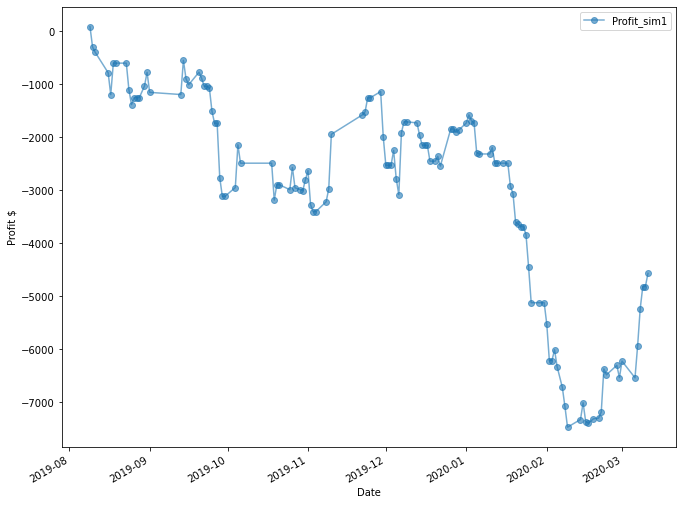

In [118]:
profit_cols = ['Profit_sim1']

ax = df_sim_res[["Date"]+profit_cols].groupby("Date").sum().cumsum().plot(alpha=0.6, marker='o', linestyle='-', figsize=(11, 9))
ax.set_ylabel("Profit $")

# 2.2 Simulation for 3 classes classification
Predict the result: home, away or draw

## Simulation

Sim 1 
$$f=\frac{\text { Edges }}{\text { Odds }}=\frac{p_{W}^{*} \times x-\left(1-p_{W}^{*}\right)}{x}$$
Where $p_{W}^{*}=\frac{1}{\frac{1}{n} \times \sum_{1}^{n} x_{i}}$

## Simulation 2

Make bet for all options: In the three options we have, each one would have bi amount of bet, depending on predicted probability and odds.

$$b_{i}=\frac{B_{i} \mathbf{1}\left(\hat{p}_{i}-1 / o_{i}\right)}{\sum_{j}^{3} B_{j} \mathbf{1}\left(\hat{p}_{j}-1 / o_{j}\right)}$$

In [90]:
class Simulation_Bet():
    def __init__(self, df, cols_needed, probas, total_budget, budget_per_game=None):
        """
        Probas: array of (n, 3) Each columns is the probability of Home, Draw and Away, respectively.
        Cols_needed: Required: "Result", 
                                'Max_Home', 'Mean_Home', 'Max_Draw', 'Mean_Draw', 'Max_Away', 'Mean_Away'           
        """
        self.n_games = df.shape[0]
        self.df_res = df.copy()[cols_needed]
        self.df_res[["H_proba", "D_proba", "A_proba"]] = probas
        self.df_res["Prediction"] = self.df_res[["H_proba", "D_proba", "A_proba"]].idxmax(axis=1).replace({"D_proba": "Draw", "A_proba": "Away", "H_proba": "Home"})
    
        if not total_budget:
            print("There are in total {} games, and budget per game is ${}.".format(n_games, budget_per_game))
        else:
            budget_per_game = total_budget/n_games
            print("There are in total {} games, total budget is ${}, and budget per game is ${}.".format(n_games, total_budget, budget_per_game))
        
        self.budget_per_game = budget_per_game
        
    def make_simulation_one(self):
        # simulation 1
        print("="*10, "Simulation 1: Make bet once at a time.","="*10)
        df_sim1 = self.df_res.copy()
        # ML model decide which result to bet on
        # With the prediction, I find the highest odds among 7 online betting houses. This means if I win, I get the highest profit possible. This will be the odds at which I place my bet.
       
        df_sim1["Selected_odd"] = np.nan
        df_sim1.loc[df_sim1["Prediction"]=="Draw", "Selected_odd"] = df_sim1["Max_Draw"]
        df_sim1.loc[df_sim1["Prediction"]=="Home", "Selected_odd"] = df_sim1["Max_Home"]
        df_sim1.loc[df_sim1["Prediction"]=="Away", "Selected_odd"] = df_sim1["Max_Away"]
        # if prediction is correct, then profit would be odd -1, else profit be -1
        df_sim1["Profit_per_dollar"] = np.where(df_sim1["Prediction"] == df_sim1["Result"], df_sim1["Selected_odd"]-1, -1)
        # Decide how much to put in (fraction)
        # We aggregate all the odds from many different betting houses, to get a better reflection of how bookmakers view the probability of an event
        df_sim1["Pw_odds"] = np.nan
        df_sim1.loc[df_sim1["Prediction"]=="Draw", "Pw_odds"] = 1/df_sim1["Mean_Draw"]
        df_sim1.loc[df_sim1["Prediction"]=="Home", "Pw_odds"] = 1/df_sim1["Mean_Home"]
        df_sim1.loc[df_sim1["Prediction"]=="Away", "Pw_odds"] = 1/df_sim1["Mean_Away"]
        df_sim1["Fraction"] = (df_sim1["Pw_odds"] * df_sim1["Selected_odd"] - (1-df_sim1["Pw_odds"] ))/df_sim1["Selected_odd"]

        df_sim1["Putin"] =  self.budget_per_game * df_sim1["Fraction"] 
        df_sim1["Profit"] = df_sim1["Putin"]  * df_sim1["Profit_per_dollar"]
        
        return df_sim1
    
    def make_simulation_two(self, Bi_type):
        # simulation 2
        print("="*10, "Simulation 2: Make multiple bets at a time.","="*10)
        print("Type of Bi is ", Bi_type)
        df_sim2 = self.df_res.copy()
        
        # Simulation 2
        # # O_i we use the mean of the odds
        # df_sim2["p_odd_Home"] =  1/df_sim2.Mean_Home
        # df_sim2["p_odd_Draw"] =  1/df_sim2.Mean_Draw
        # df_sim2["p_odd_Away"] =  1/df_sim2.Mean_Away

        # indicator for betting or not
        df_sim2["Ind_Home"] = ((df_sim2.H_proba - 1/df_sim2.Mean_Home)>0).astype("int")
        df_sim2["Ind_Draw"] =  ((df_sim2.D_proba - 1/df_sim2.Mean_Draw)>0).astype("int")
        df_sim2["Ind_Away"] =  ((df_sim2.A_proba - 1/df_sim2.Mean_Away)>0).astype("int")
        
        if Bi_type == 'unif':
            df_sim2["Bi_Home"] = 1
            df_sim2["Bi_Draw"] = 1
            df_sim2["Bi_Away"] = 1
        elif Bi_type == 'conf':
            # weights as probability # which proba to use here
            df_sim2["Bi_Home"] =  1/df_sim2.Mean_Home
            df_sim2["Bi_Draw"] =  1/df_sim2.Mean_Draw
            df_sim2["Bi_Away"] =  1/df_sim2.Mean_Away
        elif Bi_type == 'abs-disc':
            df_sim2["Bi_Home"] =  (df_sim2.H_proba - 1/df_sim2.Mean_Home)
            df_sim2["Bi_Draw"] =  (df_sim2.D_proba - 1/df_sim2.Mean_Draw)
            df_sim2["Bi_Away"] =  (df_sim2.A_proba - 1/df_sim2.Mean_Away)
        elif Bi_type == 'rel-disc':
            df_sim2["Bi_Home"] =  (df_sim2.H_proba - 1/df_sim2.Mean_Home)/ df_sim2.H_proba 
            df_sim2["Bi_Draw"] =  (df_sim2.D_proba - 1/df_sim2.Mean_Draw)/ df_sim2.D_proba
            df_sim2["Bi_Away"] =  (df_sim2.A_proba - 1/df_sim2.Mean_Away)/ df_sim2.A_proba
            
        df_sim2["Bet_Home"] = df_sim2["Bi_Home"] * df_sim2["Ind_Home"]
        df_sim2["Bet_Draw"] = df_sim2["Bi_Draw"] * df_sim2["Ind_Draw"]
        df_sim2["Bet_Away"] = df_sim2["Bi_Away"] * df_sim2["Ind_Away"]

        df_sim2["Bet_sum"] = df_sim2["Bet_Away"]  + df_sim2["Bet_Draw"]  + df_sim2["Bet_Home"] 

        df_sim2["Bet_Home_frac"] = df_sim2["Bet_Home"]/ df_sim2["Bet_sum"]
        df_sim2["Bet_Draw_frac"] = df_sim2["Bet_Draw"]/ df_sim2["Bet_sum"]
        df_sim2["Bet_Away_frac"] = df_sim2["Bet_Away"]/ df_sim2["Bet_sum"]
        
        df_sim2["Profit_per_dollar_Home"] = np.where(df_sim2["Result"]=="Home", df_sim2["Max_Home"]-1, -1)
        df_sim2["Profit_per_dollar_Draw"] = np.where(df_sim2["Result"]=="Draw", df_sim2["Max_Draw"]-1, -1)
        df_sim2["Profit_per_dollar_Away"] = np.where(df_sim2["Result"]=="Away", df_sim2["Max_Away"]-1, -1)

        df_sim2["Profit"] = self.budget_per_game * (df_sim2.Bet_Home_frac * df_sim2.Profit_per_dollar_Home + df_sim2.Bet_Draw_frac * df_sim2.Profit_per_dollar_Draw + df_sim2.Bet_Away_frac * df_sim2.Profit_per_dollar_Away)
        
        return df_sim2
            
    

### Import model here (Only probability is needed here)

In [119]:
# # Here we will need a model to predict the probability of H, D and A for each games
# Here we will need a model to predict the probability of H, notH for each games
df_tri = pd.read_csv("home_win_away_win_draw_predictions.csv")
df_tri.Date = pd.to_datetime(df_tri.Date)
# subset of 2019-2020 Season Pre-COVID
df_tri = df_tri[(df_tri.Season == '2019-2020') & (df_tri.Date<'2020-05')]
proba_tri = pd.concat([df_tri.pred_prob_home_win, df_tri.pred_prob_draw, df_tri.pred_prob_away_win],axis=1).values

# # The following part is simulated probability
# n_games = df_1920.shape[0]
# sim_proba = np.random.random((n_games, 2))
# # normalize it
# sim_proba = sim_proba/sim_proba.sum(axis=1).reshape(-1,1)
# # The following part is simulated probability
# n_games = df_1920.shape[0]
# sim_proba = np.random.random((n_games, 3))
# # normalize it
# sim_proba = sim_proba/sim_proba.sum(axis=1).reshape(-1,1)

In [92]:
# draw_p = 1- df_1920[["538Prob_Home","538Prob_Away"]].sum(axis=1)
# home_p = df_1920[["538Prob_Home"]]
# away_p = df_1920[["538Prob_Away"]]
# proba = pd.concat([home_p, draw_p, away_p],axis=1).values

In [120]:
cols =  key_cols + New_cols
# change the probability here
sim = Simulation_Bet(df_1920, cols_needed=cols, probas=proba_tri, total_budget=1_000_000, budget_per_game=None)
sim1 = sim.make_simulation_one()
# unif, conf, abs-disc, rel-disc
sim2_1 = sim.make_simulation_two("unif")
sim2_2 = sim.make_simulation_two("conf")
sim2_3 = sim.make_simulation_two("abs-disc")
sim2_4 = sim.make_simulation_two("rel-disc")

There are in total 1315 games, total budget is $1000000, and budget per game is $760.4562737642585.
========== Simulation 1: Make bet once at a time. ==========
========== Simulation 2: Make multiple bets at a time. ==========
Type of Bi is  unif
========== Simulation 2: Make multiple bets at a time. ==========
Type of Bi is  conf
========== Simulation 2: Make multiple bets at a time. ==========
Type of Bi is  abs-disc
========== Simulation 2: Make multiple bets at a time. ==========
Type of Bi is  rel-disc


In [121]:
cols = ['League', 'Season', 'Date', 'Team_Home', 'Team_Away', 'Goals_Home','Goals_Away', 'Result']
list_se = [sim1[cols] ,sim1.Profit.rename("Profit_sim1"), sim2_1.Profit.rename('Profit_sim2_unif'),
           sim2_2.Profit.rename('Profit_sim2_conf'), sim2_3.Profit.rename( 'Profit_sim2_abs-disc'),
           sim2_4.Profit.rename('Profit_sim2_rel-disc') ]
df_sim_res = pd.concat(list_se, axis=1)

Text(0, 0.5, 'Profit $')

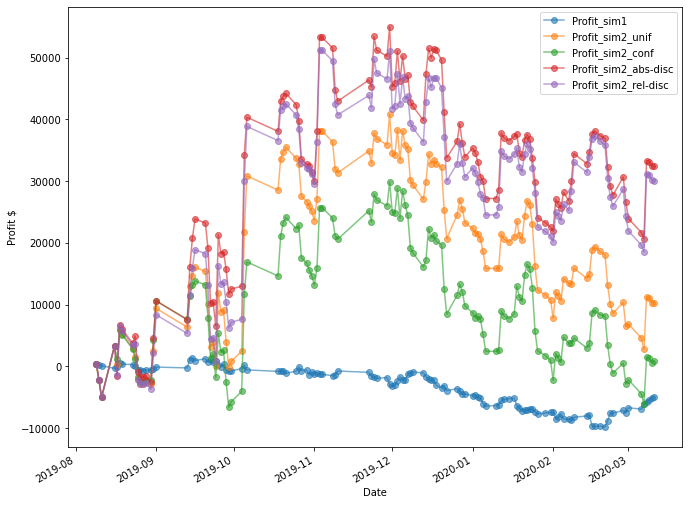

In [123]:
profit_cols = ['Profit_sim1', 'Profit_sim2_unif','Profit_sim2_conf','Profit_sim2_abs-disc', 'Profit_sim2_rel-disc']
# profit_cols = ['Profit_sim1']

ax = df_sim_res[["Date"]+profit_cols].groupby("Date").sum().cumsum().plot(alpha=0.6, marker='o', linestyle='-', figsize=(11, 9))
ax.set_ylabel("Profit $")

In [ ]:
# profit at the end 
# 

Simulation ends here

----
# Lengthy version with explaination of simulation 1 and simulation 2

In [67]:
df_1920[["H_proba", "D_proba", "A_proba"]] = sim_proba

In [70]:
df_1920["Prediction"] = df_1920[["H_proba", "D_proba", "A_proba"]].idxmax(axis=1).replace({"D_proba": "Draw", "A_proba": "Away", "H_proba": "Home"})

In [72]:
df_1920.head(2)

,League,Season,Date,Team_Home,FBREFPossession_Home,FBREFSave%_Home,FBREFAst_Home,FBREFPK_Home,FBREFPKatt_Home,FBREFSh_Home,...,Mean_Draw,Median_Draw,Max_Away,Mean_Away,Median_Away,Result,H_proba,D_proba,A_proba,Prediction
3617,Ligue1,2019-2020,2019-08-09,Monaco,39,0.0,0,0,0,7,...,3.439,3.4,2.5,2.391,2.4,Away,0.431579,0.549023,0.019398,Draw
3618,EPL,2019-2020,2019-08-09,Liverpool,57,100.0,3,0,0,15,...,9.181,9.5,23.0,19.597,19.0,Home,0.293113,0.117564,0.589323,Away


## Simulation 1

In [98]:
# Set out a fixed budget of $1000, divided equally to all previous rounds of the Premier League.
total_budget = 1_000_000
# budget_per_game is the maximum value to put into the game. We will use the Kelly criterion to decide what fraction of budget to put in each game.
budget_per_game = total_budget / n_games
# ML model decide which result to bet on
df_1920["Selected_odd"] = np.nan
df_1920.loc[df_1920["Prediction"]=="Draw", "Selected_odd"] = df_1920["Max_Draw"]
df_1920.loc[df_1920["Prediction"]=="Home", "Selected_odd"] = df_1920["Max_Home"]
df_1920.loc[df_1920["Prediction"]=="Away", "Selected_odd"] = df_1920["Max_Away"]
# With the prediction, I find the highest odds among 7 online betting houses. This means if I win, I get the highest profit possible. This will be the odds at which I place my bet.


In [95]:
# if prediction is correct, then profit would be odd -1, else profit be -1
df_1920["Profit_per_dollar"] = np.where(df_1920["Prediction"] == df_1920["Result"], df_1920["Selected_odd"]-1, -1)

$$f=\frac{\text { Edges }}{\text { Odds }}=\frac{p_{W}^{*} \times x-\left(1-p_{W}^{*}\right)}{x}$$
Where $p_{W}^{*}=\frac{1}{\frac{1}{n} \times \sum_{1}^{n} x_{i}}$

In [85]:
# Decide how much to put in (fraction)
# We aggregate all the odds from many different betting houses, to get a better reflection of how bookmakers view the probability of an event
df_1920["Pw_odds"] = np.nan
df_1920.loc[df_1920["Prediction"]=="Draw", "Pw_odds"] = 1/df_1920["Mean_Draw"]
df_1920.loc[df_1920["Prediction"]=="Home", "Pw_odds"] = 1/df_1920["Mean_Home"]
df_1920.loc[df_1920["Prediction"]=="Away", "Pw_odds"] = 1/df_1920["Mean_Away"]

df_1920["Fraction"] = (df_1920["Pw_odds"] * df_1920["Selected_odd"] - (1-df_1920["Pw_odds"] ))/df_1920["Selected_odd"]

In [102]:
df_1920["Putin"] =  budget_per_game * df_1920["Fraction"] 
df_1920["Profit"] = df_1920["Putin"]  * df_1920["Profit_per_dollar"]

<AxesSubplot:>

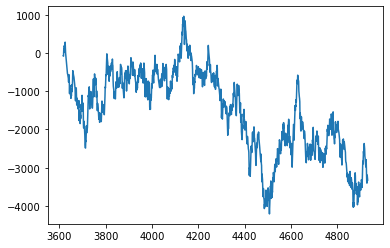

In [104]:
df_1920["Profit"].cumsum().plot()

## Simulation 2

Make bet for all options: In the three options we have, each one would have bi amount of bet, depending on predicted probability and odds.

$$b_{i}=\frac{B_{i} \mathbf{1}\left(\hat{p}_{i}-1 / o_{i}\right)}{\sum_{j}^{3} B_{j} \mathbf{1}\left(\hat{p}_{j}-1 / o_{j}\right)}$$

In [107]:
# # O_i we use the mean of the odds
# df_1920["p_odd_Home"] =  1/df_1920.Mean_Home
# df_1920["p_odd_Draw"] =  1/df_1920.Mean_Draw
# df_1920["p_odd_Away"] =  1/df_1920.Mean_Away

# indicator for betting or not
df_1920["Ind_Home"] = ((df_1920.H_proba - 1/df_1920.Mean_Home)>0).astype("int")
df_1920["Ind_Draw"] =  ((df_1920.D_proba - 1/df_1920.Mean_Draw)>0).astype("int")
df_1920["Ind_Away"] =  ((df_1920.A_proba - 1/df_1920.Mean_Away)>0).astype("int")


df_1920["Bi_Home"] = 1
df_1920["Bi_Draw"] = 1
df_1920["Bi_Away"] = 1

df_1920["Bet_Home"] = df_1920["Bi_Home"] * df_1920["Ind_Home"]
df_1920["Bet_Draw"] = df_1920["Bi_Draw"] * df_1920["Ind_Draw"]
df_1920["Bet_Away"] = df_1920["Bi_Away"] * df_1920["Ind_Away"]

df_1920["Bet_sum"] = df_1920["Bet_Away"]  + df_1920["Bet_Draw"]  + df_1920["Bet_Home"] 

df_1920["Bet_Home_frac"] = df_1920["Bet_Home"]/ df_1920["Bet_sum"]
df_1920["Bet_Draw_frac"] = df_1920["Bet_Draw"]/ df_1920["Bet_sum"]
df_1920["Bet_Away_frac"] = df_1920["Bet_Away"]/ df_1920["Bet_sum"]

In [118]:
df_1920["Profit_per_dollar_Home"] = np.where(df_1920["Result"]=="Home", df_1920["Max_Home"]-1, -1)
df_1920["Profit_per_dollar_Draw"] = np.where(df_1920["Result"]=="Draw", df_1920["Max_Draw"]-1, -1)
df_1920["Profit_per_dollar_Away"] = np.where(df_1920["Result"]=="Away", df_1920["Max_Away"]-1, -1)

In [119]:
df_1920["Profit_2"] = budget_per_game * (df_1920.Bet_Home_frac * df_1920.Profit_per_dollar_Home + df_1920.Bet_Draw_frac * df_1920.Profit_per_dollar_Draw + df_1920.Bet_Away_frac * df_1920.Profit_per_dollar_Away)

In [122]:
df_1920["Profit_2"].cumsum()

3617     -760.456274
3618    -1520.912548
3619    -1250.950570
3620    -2011.406844
3621    -1376.425856
            ...     
4927    39254.752852
4928    38494.296578
4929    37733.840304
4930    36973.384030
4931    36212.927757
Name: Profit_2, Length: 1315, dtype: float64